<a href="https://colab.research.google.com/github/bjk95/Machine-Learning-for-Finance/blob/master/embeddings_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecaster using embeddings

This model will create a tensorflow model from multiple inputs used to create product level predictions of what indivudual customers will purchase.

# Loading modules and verifiying gdrive is connected

In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, LSTM, Input, Embedding, Reshape
from tensorflow.python.keras.layers.merge import Dot, Concatenate, Multiply
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K
from tensorflow.python.keras.initializers import Constant
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.layers import ReLU, ELU
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import set_random_seed
from seaborn import distplot
from scipy.stats import describe
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils import plot_model
import pydotplus as pydot
import time
import pickle
import os
import pprint

#!pip install talos
#import talos as ta

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

try:
  from google.colab import drive
  drive.mount('/gdrive')
  main_path = '/gdrive/My Drive/sales_forecaster'
  
except:
  main_path = None
  
# Number of epochs to train across
epochs = 20

# Learning rate
lr = 0.001

# Size of embeddings
embedding_size = 10


TPU address is grpc://10.14.130.2:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 3898210708052493884),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1544304800370930010),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1109443748420640575),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1559955375496699192),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 590191951051409967),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 8195322843755495140),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4226372267252723405),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12900642782005741714),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 62738959000033490

In [2]:
print(os.listdir('/gdrive/My Drive/sales_forecaster'))

['models', 'histories', 'material_codes.csv', 'customer_codes.csv', 'top20.csv', 'tsne_dot_customer.csv', 'tsne_dot_material.csv']


# Importing data and data exploration

In this section we will import a sample set of the Pact sales data stored in a .csv, perform basic data exploration and reformat data for training.

In [3]:
summary = pd.read_csv('/gdrive/My Drive/sales_forecaster/top20.csv')
print(summary.describe())
print(summary.head())

        Unnamed: 0         custID   materialID  PeriodBlock          order
count  6612.000000    6612.000000  6612.000000  6612.000000    6612.000000
mean   3305.500000   33246.263158  3268.275862     6.500000    1564.312231
std    1908.864322   50129.807722  1710.808703     3.452314   20352.675674
min       0.000000    2203.000000    20.000000     1.000000       0.000000
25%    1652.750000   10685.000000  1897.000000     3.750000       0.000000
50%    3305.500000   17048.000000  3729.000000     6.500000      73.951202
75%    4958.250000   28975.000000  4883.000000     9.250000     397.661068
max    6611.000000  211793.000000  5409.000000    12.000000  777285.494656
   Unnamed: 0  custID  materialID  PeriodBlock  order
0           0    2203          78            1    0.0
1           1    2203          78            2    0.0
2           2    2203          78            3    0.0
3           3    2203          78            4    0.0
4           4    2203          78            5    0.0


In [4]:
customer_codes = pd.read_csv('/gdrive/My Drive/sales_forecaster/customer_codes.csv')
print(customer_codes.head())

material_codes = pd.read_csv('/gdrive/My Drive/sales_forecaster/material_codes.csv')
print(material_codes.head())

   customerID  custID IndustryKey                CustomerName
0           0    2025        V121                FCC TAURANGA
1           1    2101        V033     VISY  - CREDIT SERVICES
2           2    2202        V121           VIP - HEAD OFFICE
3           3    2206        V121  VIP PLASTICS  - CHELTENHAM
4           4    2214        V121       VIP TUBES - NTH ROCKS
   materialID         prodID                  MaterialName
0           0             AH  Agribusiness & Horticultural
1           1          AHC74                    HERBICIDES
2           2      AHC74C533                        LIQUID
3           3  AHC74C533ZZZZ                   Unallocated
4           4      AHC74C546                        POWDER


In [5]:
summary = pd.merge(summary, customer_codes, on='custID')
summary = pd.merge(summary, material_codes, on='materialID')
print(summary.head())
print(summary.shape)

   Unnamed: 0  custID  materialID  PeriodBlock  order  customerID IndustryKey  \
0           0    2203          78            1    0.0        5290        V121   
1           1    2203          78            2    0.0        5290        V121   
2           2    2203          78            3    0.0        5290        V121   
3           3    2203          78            4    0.0        5290        V121   
4           4    2203          78            5    0.0        5290        V121   

               CustomerName prodID           MaterialName  
0  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
1  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
2  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
3  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
4  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
(6612, 10)


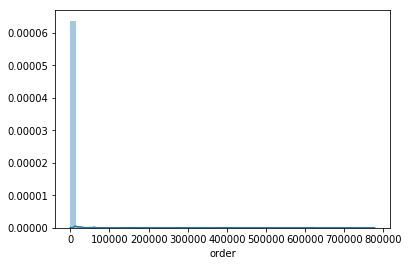

In [6]:
distplot(summary.order)

Here we can see that the value of product orders follow an extreme Pareto distribution. This make the data difficult to train on, therefore we shall try a log transformation to see if that gives us more meaningful data.

*N.B. We will have to reverse this transform at the end to rescale the data.*

[0.         0.         0.         ... 4.25245315 4.51219104 4.53545929]


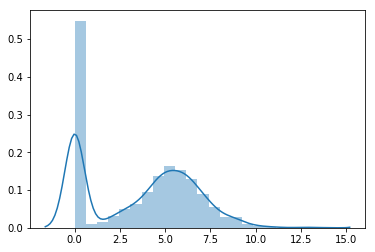

In [7]:
def log(data):
  x = np.ma.log(np.array(data))
  print(x.filled(0))
  
  return x

distplot(log(summary.order).clip(0))

Now we have applied the log tranformation we can see that our data follows a much more consistently distributed pattern. As our data includes 0s we  defined a function that imposes a log transformation while ignoring 0s. To do so, we used a masked numpy array.

In [0]:
def scale(data, maximum):
  data = data - min(data)
  data = data / max(data)
  data = data * maximum
  
  return data

In [9]:
customers = summary.custID.unique()
customer_map = {i:val for i,val in enumerate(customers)}
inverse_customer_map = {val:i for i,val in enumerate(customers)}
materials = summary.materialID.unique()
material_map = {i:val for i,val in enumerate(materials)}
inverse_material_map = {val:i for i,val in enumerate(materials)}

summary['period_material'] = summary['materialID'].map(str) + 'M' + summary['PeriodBlock'].map(str)

materials = summary.period_material.unique()
material_map = {i:val for i,val in enumerate(materials)}
inverse_period_material_map = {val:i for i,val in enumerate(materials)}

df = pd.DataFrame()
df["old_customer_id"] = summary['custID']
df["customer_name"] = summary['CustomerName']
df["customer_id"] = summary["custID"].map(inverse_customer_map)
df["old_material_id"] = summary["materialID"]# copying for join with metadata
df["material_name"] = summary['MaterialName']
df["material_id"] = summary["materialID"].map(inverse_material_map)
df['period_material'] = summary.period_material.map(inverse_period_material_map)
df['order'] = log(summary.order).clip(0)
#df['order'] = scale(df['order'], 10)


print("Descriptive statistics of our transformed data \n")
print(df.describe())
print("\n An example of the top 10 entries of our data \n")
print(df.head(10))

[0.         0.         0.         ... 4.25245315 4.51219104 4.53545929]
Descriptive statistics of our transformed data 

       old_customer_id  customer_id  old_material_id  material_id  \
count      6612.000000  6612.000000      6612.000000  6612.000000   
mean      33246.263158     6.261343      3268.275862    47.940109   
std       50129.807722     5.042917      1710.808703    40.904041   
min        2203.000000     0.000000        20.000000     0.000000   
25%       10685.000000     2.000000      1897.000000    12.000000   
50%       17048.000000     5.000000      3729.000000    40.000000   
75%       28975.000000     9.000000      4883.000000    71.000000   
max      211793.000000    19.000000      5409.000000   152.000000   

       period_material        order  
count      6612.000000  6612.000000  
mean        580.781307     3.606152  
std         490.860632     2.963164  
min           0.000000     0.000000  
25%         149.000000     0.000000  
50%         484.000000     4.

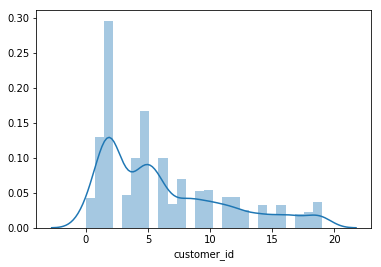

In [10]:
distplot(df.customer_id)

Here we can see there are no major anomalies in our customer ID set

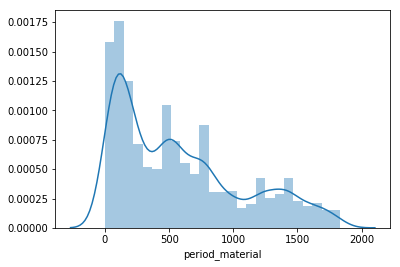

In [11]:
distplot(df.period_material)

Here we can see there are no major anomalies in our customer ID set.

Now we can move onto creating our model.

# Matrix Factorisation approach

Here we will create our first simple model based on matrix factorisation. We create here an embedding for customers and materials. The dot product between these two items give us our predictions

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.14.130.2:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3898210708052493884)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1544304800370930010)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1109443748420640575)
INFO:tensorflow:*** Availab

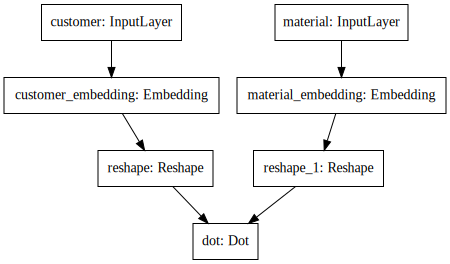

In [12]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=embedding_size

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

y = Dot(1, normalize=False)([customer_vecs, material_vecs])

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

adam = Adam(lr=lr)

model.compile(loss='mse',
              optimizer=adam
             )

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Here we have a representation of our model. It takes two inputs which are then embedded and reshaped before the dot product of the two is taken.

Below we define our callback to take checkpoints throughout the models training

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_50_' + mytime 
matrix_modname = modname
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

Now we can train the model

In [14]:
history = model.fit([df["customer_id"], df["period_material"]]
                    , df["order"]
                    , batch_size=64 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 6612 samples, validate on 662 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='customer_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='material_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dot_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for customer
INFO:tensorflow:Remapping placeholder for material
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fcf05e9a8d0> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.3386633396148682 secs
INFO:tensorflow:Setting weights

Now we can examine the historiy file

/gdrive/My Drive/sales_forecaster/histories/matrix_facto_50_2019_04_24_06_24.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,21.784625,21.776075,21.769045,21.762948,21.727474,21.673329,21.622856,21.515913,21.378393,21.188398,20.963156,20.704228,20.401401,20.068529,19.693846,19.290397,18.860628,18.384989,17.905251,17.383874
val_loss,22.188957,22.183261,22.173781,22.157363,22.130447,22.087276,22.025212,21.939123,21.824608,21.684275,21.511213,21.309630,21.080174,20.817374,20.532175,20.214168,19.876671,19.506568,19.121464,18.712650


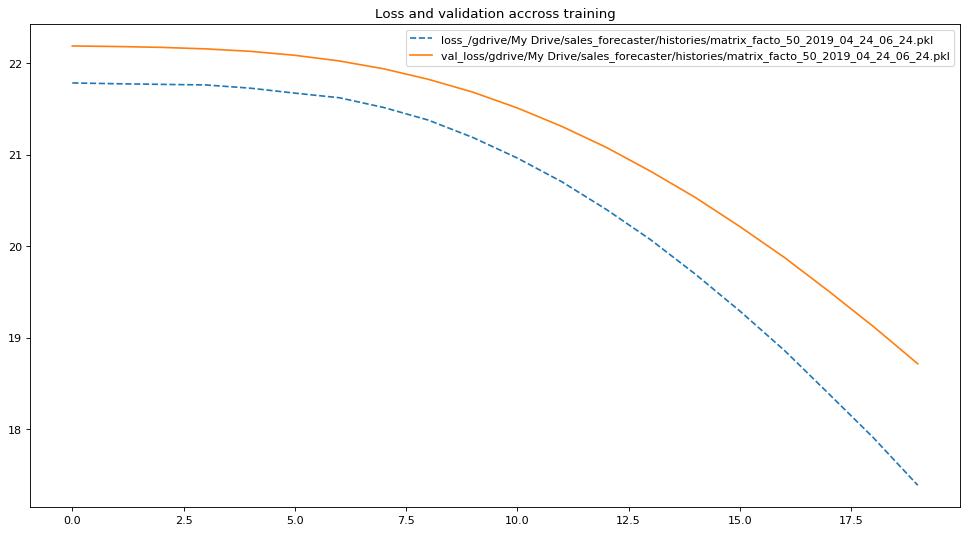

In [15]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

# Deep keras model

The architecture above is trying to predict purchases by performing a dot product. We can relax the dot assumption and instead use a oconcatnation layer followed by a dense layer. This means that instead of relying on a simple dot product, the network can find itself the way it want to combine the data non-linearly.

To do so, we shall use a two layer deep neural network using tensorflow's high-level API, keras. 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 10)        66120       customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 10)        66120       material[0][0]                   
__________________________________________________________________________________________________
reshape (R

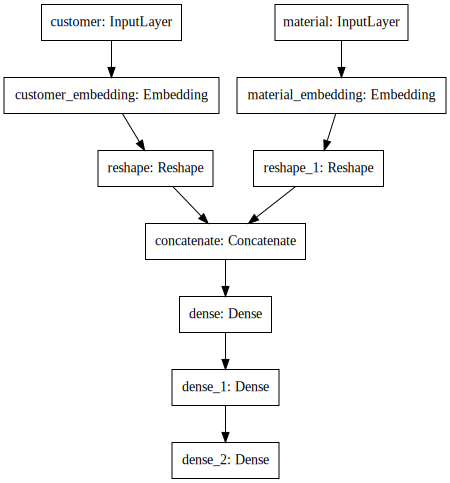

In [16]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=embedding_size

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

input_vecs = Concatenate()([customer_vecs, material_vecs])

d1 = Dense(64, activation='relu')(input_vecs)
d2 = Dense(32, activation='relu')(d1)

y = Dense(1)(d2)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Here we have a representation of our model. It takes two inputs which are then embedded and reshaped before being concatenated and fed into a 2 layer deep neural network, before a final deep layer. 

Below we define our callback to take checkpoints throughout the models training

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'dense_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

Now we can train our deep model

In [18]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 98us/sample - loss: 21.5244 - val_loss: 21.7292
Epoch 2/20
5950/5950 [==============================] - 0s 17us/sample - loss: 21.0080 - val_loss: 21.2092
Epoch 3/20
5950/5950 [==============================] - 0s 18us/sample - loss: 20.3794 - val_loss: 20.5680
Epoch 4/20
5950/5950 [==============================] - 0s 15us/sample - loss: 19.5571 - val_loss: 19.7575
Epoch 5/20
5950/5950 [==============================] - 0s 16us/sample - loss: 18.4933 - val_loss: 18.7417
Epoch 6/20
5950/5950 [==============================] - 0s 16us/sample - loss: 17.0957 - val_loss: 17.4850
Epoch 7/20
5950/5950 [==============================] - 0s 16us/sample - loss: 15.3376 - val_loss: 15.9560
Epoch 8/20
5950/5950 [==============================] - 0s 16us/sample - loss: 13.2027 - val_loss: 14.2397
Epoch 9/20
5950/5950 [==============================] - 0s 15us/sample - loss: 10.8917 - val_loss

/gdrive/My Drive/sales_forecaster/histories/dense_facto_50_2019_04_24_06_24.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,21.524406,21.008049,20.379425,19.557139,18.493295,17.095698,15.337574,13.202653,10.891687,8.864815,7.669165,7.250625,6.973048,6.519062,6.188375,5.953976,5.770239,5.647754,5.578852,5.537498
val_loss,21.729164,21.209192,20.567993,19.757509,18.741678,17.484974,15.956036,14.239656,12.525323,11.162215,10.441741,10.267463,10.318677,10.536810,10.797456,11.015094,11.151165,11.280454,11.409049,11.560425


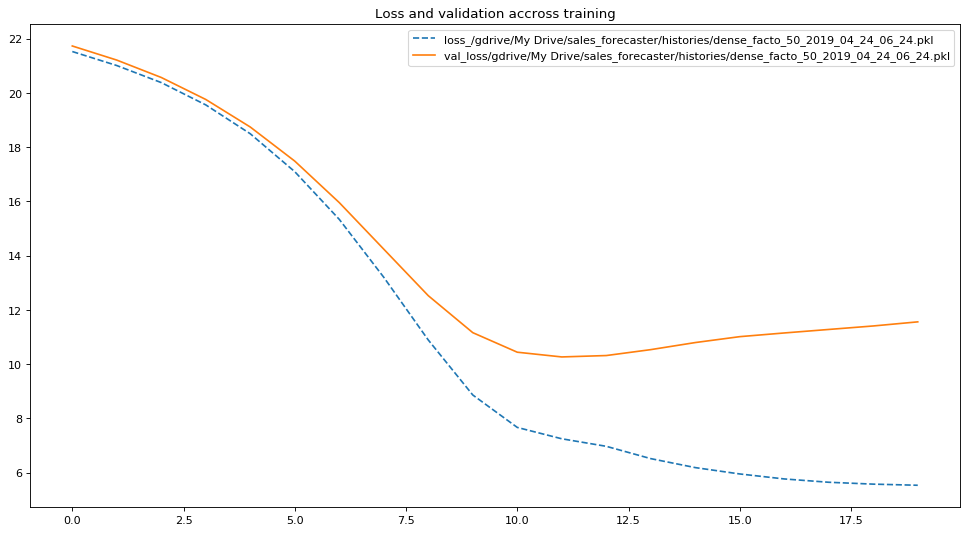

In [19]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

Having completed training we can see that the model quickly converges to its optimal fit with the relatively flat validation loss accross all epochs of training.


Now we want to compare the models. Just below we define a function to find the history of the most recent run of each model type to compare the results

In [0]:
def find_last(string):
    hists = pd.DataFrame(os.listdir('/gdrive/My Drive/sales_forecaster/histories'))

    x = 0
    found = False
    while found != True:
      x = x-1
      found = hists.iloc[x].str.startswith(string).item()
   
    history = hists.iloc[x]
    
    return history

matrix_facto_50_2019_04_24_06_24.pkl
dense_facto_50_2019_04_24_06_24.pkl


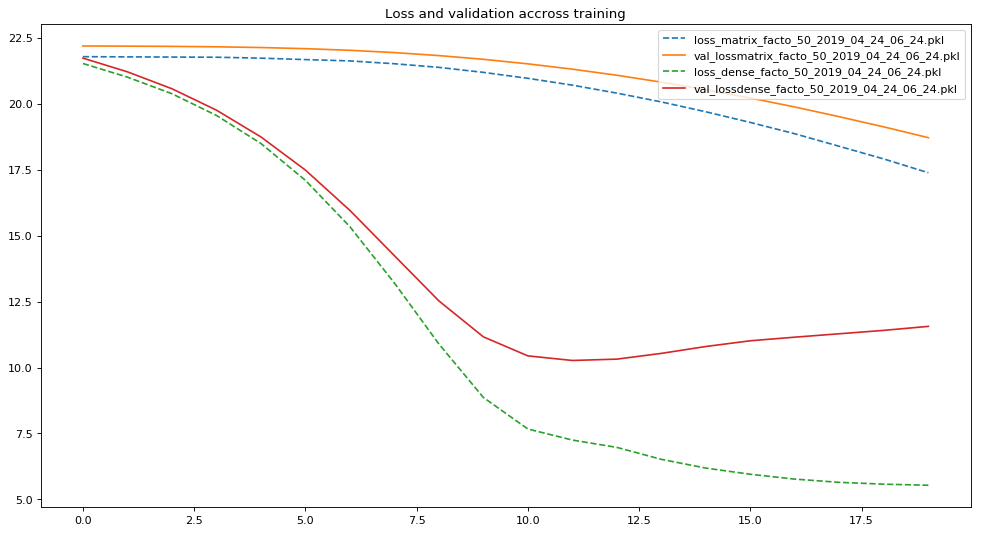

In [21]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")


This shows that although the training loss for both models is similar, although, the validation loss, hence, the actual performace of the deep model is somewhat superior.

Obviously, the performance improved significantly! Validation loss is practically cut in half. We can also notice the following points:


*   we converge really fast to the best model. After one or two epoch, the model starts overfitting or at least the validation loss does not seem to stabily go down anymore.
*   There is a large gap between training loss and validation loss (2.5 to 5 times depending on the model!), this suggests that maybe we could improve our performace by implementing a dropout layer or using a leaky ReLU / ELU activation function)



# Enhancing model architecture

The architecture defined above is simple. Indeed, it's either a dot product between embeddings or a concat layer before two dense layers. In the following we will try to gain performance by modifying the architecture of the network.

Here are a few idea I we are going to test:

* Change the dot/concat merge layer by a multiply. The idea here would be to relax the dot product so that the network can choose it's own weighted dot product, but at the same time keep the multipliction structure.
* The second idea is to try to improve the dot network by making it deeper. The problem is we cannot add a dense layer after the dot prodict since we are left with only one scalar value. An idea could be to add these dense layers before the dot product and have two "towers in" the architecture.
* We can use this idea with other architectures and create a network with two dense layers on embeddings, a concat layer, and then other dense layers.

Let's make this a little more concrete. With keras the first idea gives us:

## Experiment 1: Using Multiply merge layer instead of Concat.

This model implemented the same architecture as the previous Dense model with the exception of the input_vecs layer, the one that is used to concatnate the different inputs to then be fed through the Dense layers. 

By relaxing the dot product so that the network can choose it's own weighted dot product,it allows the model to keep the same multiplication struture while allow extra freedom to the Dense layers to factor in non-linearities.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]                   
__________________________________________________________________________________________________
reshape (R

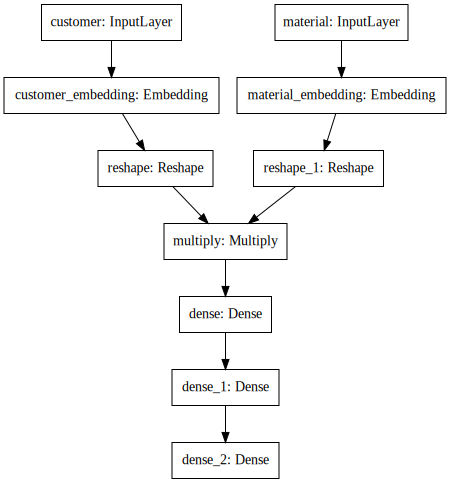

In [22]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

#customer_vecs = Dense(64, activation='relu')(customer_vecs)
#material_vecs = Dense(64, activation='relu')(material_vecs)

input_vecs = Multiply()([customer_vecs, material_vecs])
#input_vecs = Dropout(0.2)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)

adam = Adam(lr=lr)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
model.compile(optimizer=adam, loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'multiply_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [24]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 97us/sample - loss: 21.6269 - val_loss: 21.8963
Epoch 2/20
5950/5950 [==============================] - 0s 23us/sample - loss: 21.2992 - val_loss: 21.5426
Epoch 3/20
5950/5950 [==============================] - 0s 35us/sample - loss: 20.9093 - val_loss: 21.1239
Epoch 4/20
5950/5950 [==============================] - 0s 29us/sample - loss: 20.4473 - val_loss: 20.6267
Epoch 5/20
5950/5950 [==============================] - 0s 30us/sample - loss: 19.8906 - val_loss: 20.0391
Epoch 6/20
5950/5950 [==============================] - 0s 33us/sample - loss: 19.2288 - val_loss: 19.3498
Epoch 7/20
5950/5950 [==============================] - 0s 25us/sample - loss: 18.4380 - val_loss: 18.5504
Epoch 8/20
5950/5950 [==============================] - 0s 30us/sample - loss: 17.5022 - val_loss: 17.6397
Epoch 9/20
5950/5950 [==============================] - 0s 29us/sample - loss: 16.4048 - val_loss

/gdrive/My Drive/sales_forecaster/histories/multiply_facto_50_2019_04_24_06_24.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,21.626936,21.299175,20.909278,20.447300,19.890641,19.228766,18.438026,17.502179,16.404849,15.131007,13.707178,12.155989,10.551298,9.034403,7.782914,6.922808,6.412611,5.966657,5.422750,4.933779
val_loss,21.896296,21.542585,21.123932,20.626736,20.039131,19.349848,18.550428,17.639725,16.617918,15.503849,14.338730,13.167905,12.070675,11.137527,10.459325,10.103039,10.032186,10.194250,10.582022,11.147120


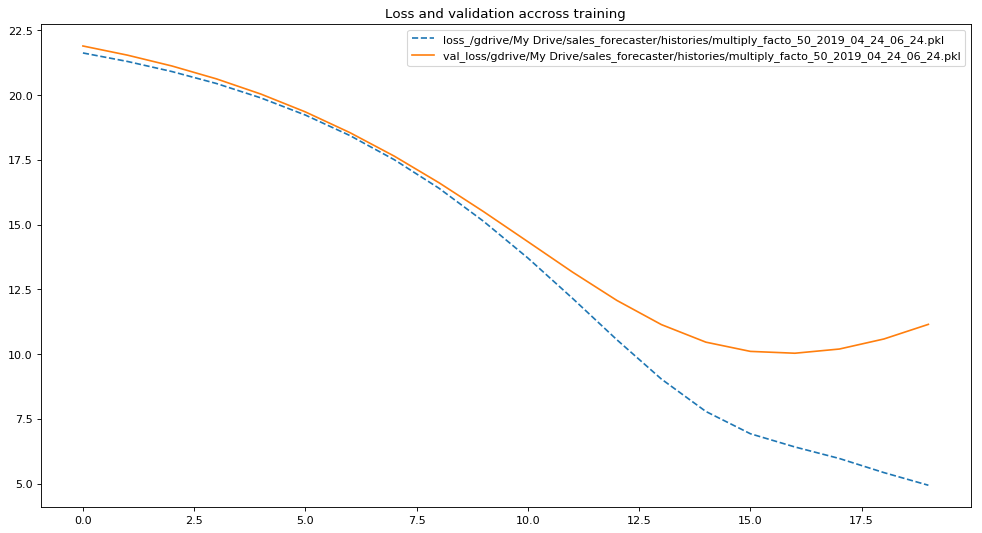

In [25]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

matrix_facto_50_2019_04_24_06_24.pkl
dense_facto_50_2019_04_24_06_24.pkl
multiply_facto_50_2019_04_24_06_24.pkl


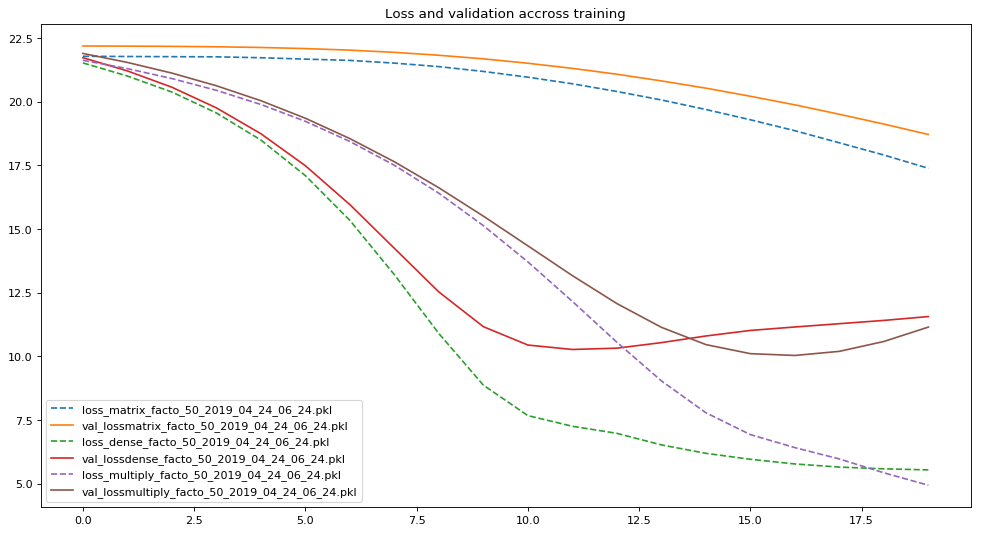

In [26]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())
histories.append(find_last('multiply').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='lower left')
        plt.title("Loss and validation accross training")

## Experiment 2: Adding a dropout layer

Large neural nets trained on relatively small datasets can overfit the training data.

This has the effect of the model learning the statistical noise in the training data, which results in poor performance when the model is evaluated on new data, e.g. a test dataset. Generalization error increases due to overfitting.

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections

Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.

This conceptualization suggests that perhaps dropout breaks-up situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]              

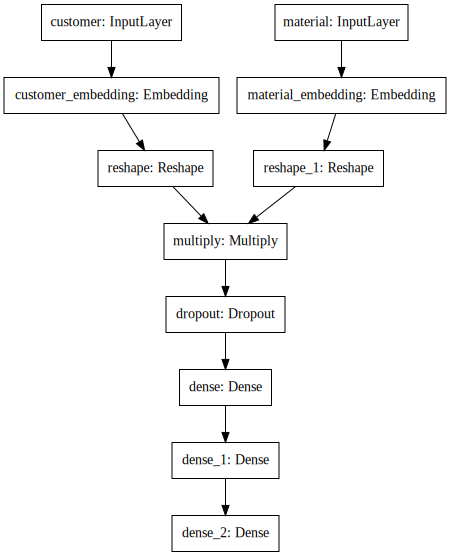

In [27]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

#customer_vecs = Dense(64, activation='relu')(customer_vecs)
#material_vecs = Dense(64, activation='relu')(material_vecs)

input_vecs = Multiply()([customer_vecs, material_vecs])
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)

adam = Adam(lr=lr)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
model.compile(optimizer=adam, loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'dropout_towers_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [29]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 107us/sample - loss: 21.5871 - val_loss: 21.8040
Epoch 2/20
5950/5950 [==============================] - 0s 22us/sample - loss: 21.1679 - val_loss: 21.3487
Epoch 3/20
5950/5950 [==============================] - 0s 36us/sample - loss: 20.6617 - val_loss: 20.8029
Epoch 4/20
5950/5950 [==============================] - 0s 30us/sample - loss: 20.0506 - val_loss: 20.1450
Epoch 5/20
5950/5950 [==============================] - 0s 28us/sample - loss: 19.3074 - val_loss: 19.3592
Epoch 6/20
5950/5950 [==============================] - 0s 34us/sample - loss: 18.4142 - val_loss: 18.4370
Epoch 7/20
5950/5950 [==============================] - 0s 25us/sample - loss: 17.3559 - val_loss: 17.3800
Epoch 8/20
5950/5950 [==============================] - 0s 30us/sample - loss: 16.1078 - val_loss: 16.2091
Epoch 9/20
5950/5950 [==============================] - 0s 30us/sample - loss: 14.7125 - val_los

/gdrive/My Drive/sales_forecaster/histories/dropout_towers_50_2019_04_24_06_24.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,21.587056,21.167905,20.661729,20.050597,19.307424,18.414150,17.355915,16.107830,14.712484,13.174415,11.569237,9.993989,8.610192,7.522030,6.823964,6.334113,5.827969,5.200824,4.671376,4.289454
val_loss,21.804031,21.348669,20.802855,20.144981,19.359215,18.437021,17.380043,16.209053,14.952289,13.670670,12.442582,11.368442,10.542436,10.033016,9.820103,9.815239,9.972876,10.284691,10.711339,11.140639


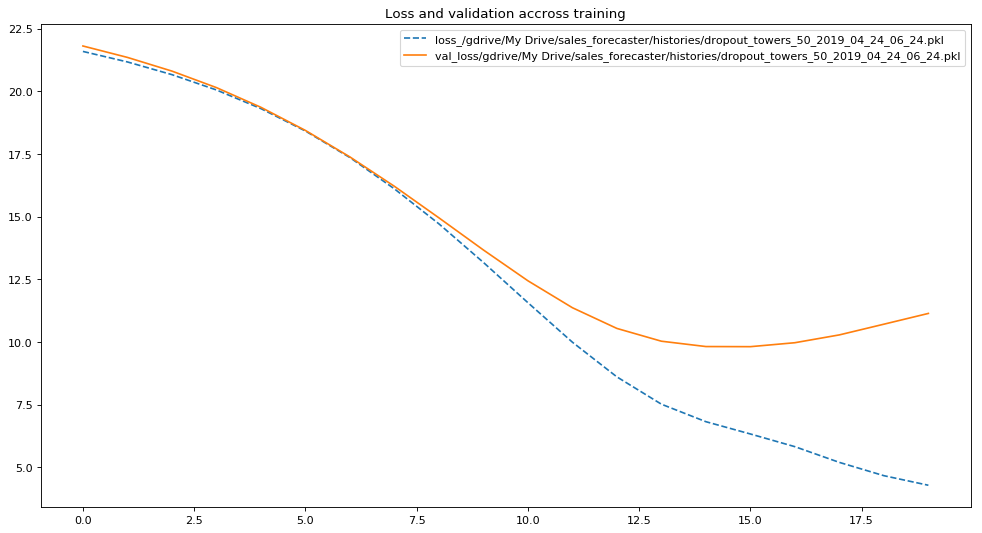

In [30]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

matrix_facto_50_2019_04_24_06_24.pkl
dense_facto_50_2019_04_24_06_24.pkl
multiply_facto_50_2019_04_24_06_24.pkl
dropout_towers_50_2019_04_24_06_24.pkl


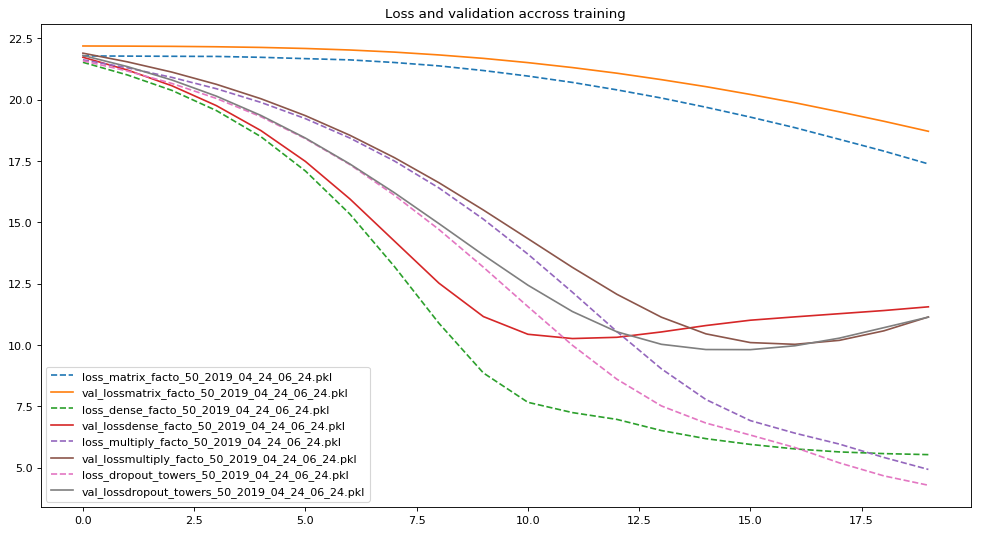

In [31]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())
histories.append(find_last('multiply').item())
histories.append(find_last('dropout').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='lower left')
        plt.title("Loss and validation accross training")

As we can see here by adding a dropout layer we can somewhat reduce the effects of overtraining allowing us to create more complex models

## Experiement 3: Increase model depth

By making a model deeper we increase its potential power. 

The problem is that we cannot adda dense layer after the dot product since we are left with only one scalar value. Therefore, we shall instead add these dense layers before the dot product creating two "towers" in the architecture.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]                   
__________________________________________________________________________________________________
reshape (R

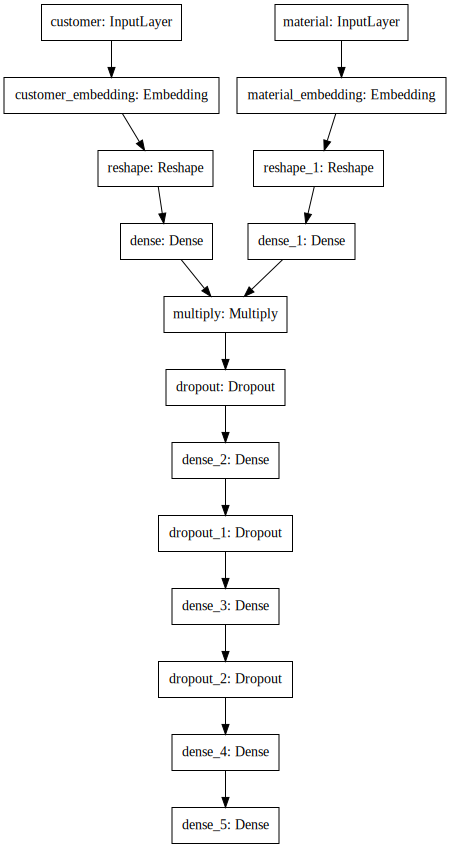

In [32]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

customer_vecs = Dense(64, activation='relu')(customer_vecs)
material_vecs = Dense(64, activation='relu')(material_vecs)

input_vecs = Multiply()([customer_vecs, material_vecs])
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x) # Add droupout or not 
x = Dense(64, activation='relu')(x) # Add dense again or not 
x = Dropout(0.2)(x) # Add droupout or not 
x = Dense(32, activation='relu')(x) # Add dense again or not 

y = Dense(1)(x)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'towers_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [34]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 204us/sample - loss: 21.5898 - val_loss: 21.7850
Epoch 2/20
5950/5950 [==============================] - 0s 35us/sample - loss: 21.1110 - val_loss: 21.2082
Epoch 3/20
5950/5950 [==============================] - 0s 39us/sample - loss: 20.4166 - val_loss: 20.3793
Epoch 4/20
5950/5950 [==============================] - 0s 35us/sample - loss: 19.4149 - val_loss: 19.1904
Epoch 5/20
5950/5950 [==============================] - 0s 36us/sample - loss: 17.9444 - val_loss: 17.5189
Epoch 6/20
5950/5950 [==============================] - 0s 35us/sample - loss: 15.8459 - val_loss: 15.2530
Epoch 7/20
5950/5950 [==============================] - 0s 41us/sample - loss: 12.9079 - val_loss: 12.4749
Epoch 8/20
5950/5950 [==============================] - 0s 40us/sample - loss: 9.4525 - val_loss: 10.0598
Epoch 9/20
5950/5950 [==============================] - 0s 36us/sample - loss: 8.0918 - val_loss:

/gdrive/My Drive/sales_forecaster/histories/towers_50_2019_04_24_06_25.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,21.589777,21.110959,20.416561,19.414858,17.944389,15.845892,12.907866,9.452487,8.091752,7.957535,7.141465,6.809993,6.326914,6.229856,5.997350,5.906969,5.910464,5.815978,5.715974,5.675154
val_loss,21.784962,21.208174,20.379307,19.190380,17.518909,15.253040,12.474901,10.059802,9.634250,9.754372,10.169523,10.205297,10.123587,10.472684,10.874181,10.920335,11.100606,11.347379,11.401472,11.582871


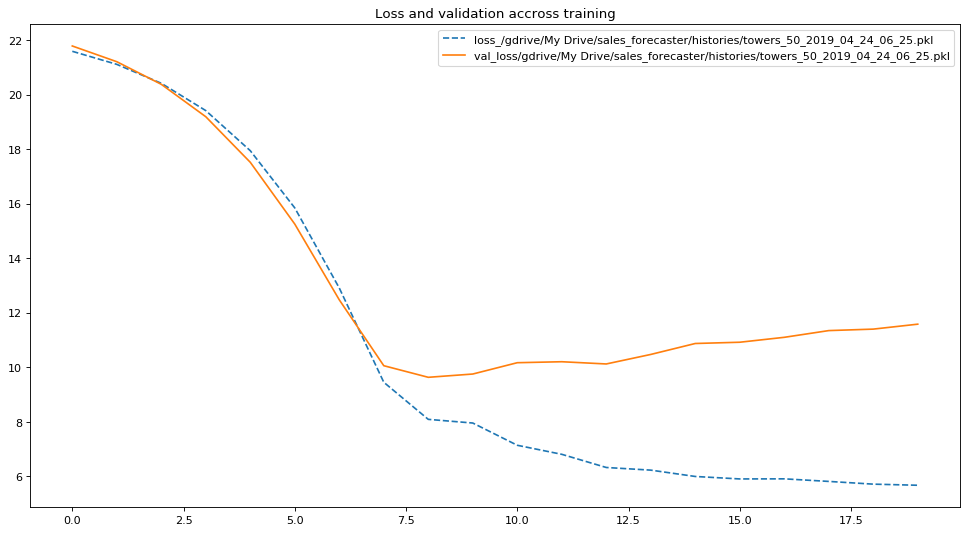

In [35]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

matrix_facto_50_2019_04_24_06_24.pkl
dense_facto_50_2019_04_24_06_24.pkl
multiply_facto_50_2019_04_24_06_24.pkl
dropout_towers_50_2019_04_24_06_24.pkl
towers_50_2019_04_24_06_25.pkl


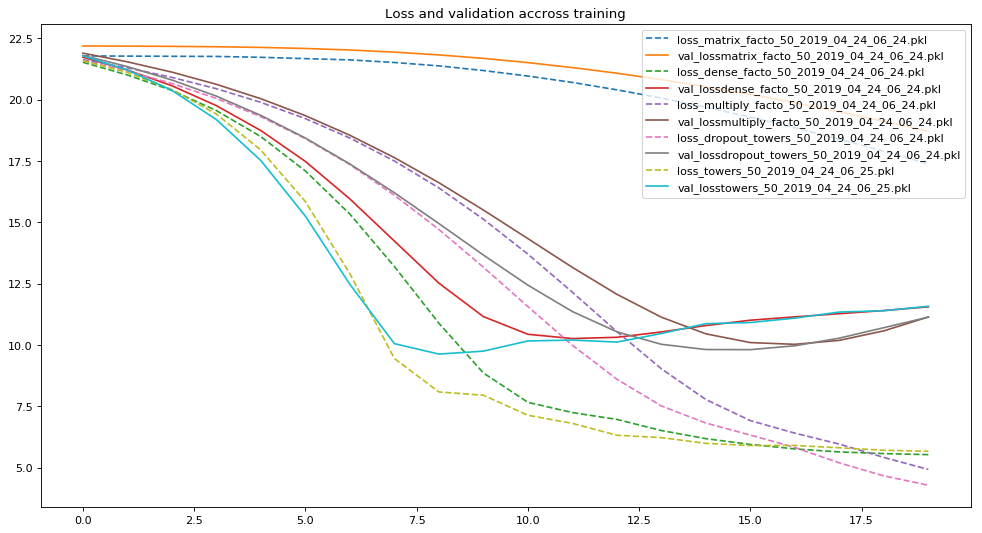

In [36]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())
histories.append(find_last('multiply').item())
histories.append(find_last('dropout').item())
histories.append(find_last('towers').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")

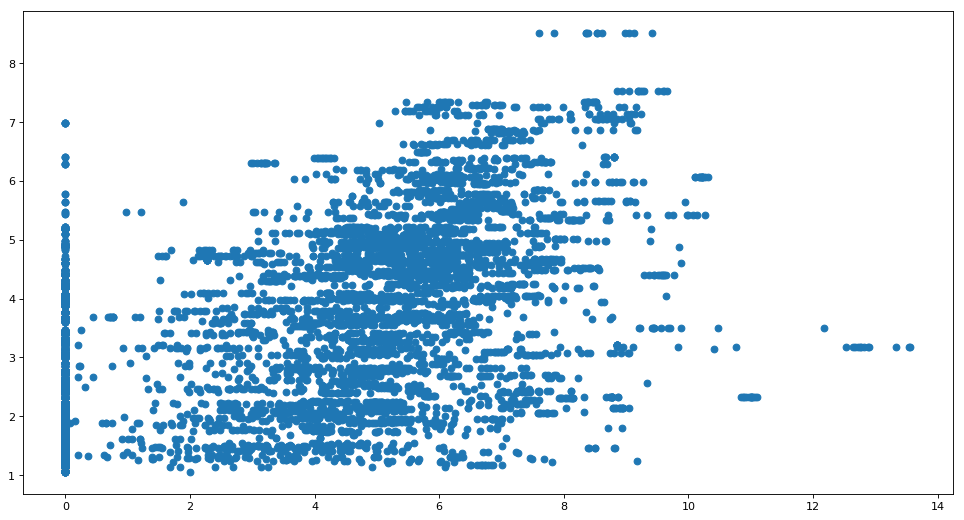

In [37]:
predictions = model.predict([df["customer_id"], df["material_id"]]) 

comparison = pd.concat([df['order'], pd.DataFrame(predictions).astype('float64').clip(0)], axis=1)
df['preditions'] = predictions

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(df['order'], predictions)


# Investigating embeddings

**Looking at most similar materials and customers**



In [38]:
print(df.head())

   old_customer_id             customer_name  customer_id  old_material_id  \
0             2203  VIP STEEL  -   TRUGANINA            0               78   
1             2203  VIP STEEL  -   TRUGANINA            0               78   
2             2203  VIP STEEL  -   TRUGANINA            0               78   
3             2203  VIP STEEL  -   TRUGANINA            0               78   
4             2203  VIP STEEL  -   TRUGANINA            0               78   

           material_name  material_id  period_material  order  preditions  
0  Food Beverage Closure            0                0    0.0    3.683209  
1  Food Beverage Closure            0                1    0.0    3.683209  
2  Food Beverage Closure            0                2    0.0    3.683209  
3  Food Beverage Closure            0                3    0.0    3.683209  
4  Food Beverage Closure            0                4    0.0    3.683209  


In [39]:
mats = pd.DataFrame(df['old_material_id'].unique(), columns=['materialID'])
mats = pd.merge(mats, material_codes, on='materialID')
print(mats.head(10))

material_info = pd.DataFrame()
material_info['name'] = mats['MaterialName']

material_info["map_id"]=mats["materialID"].map(inverse_material_map)
namesdic = {row[1]['material_id']:row[1]['material_name']  for row in df.iterrows()}

print(len(namesdic))

   materialID prodID           MaterialName
0          78  CDB29  Food Beverage Closure
1         274  CDC24      Specialty Closure
2        1096  IPA04        MGB - Equipment
3        2880  MPB33       General Line Can
4        3123  MPC27             Steel Drum
5        3305  MPC37          Tinplate Pail
6        3508  OTB58   Other Charges / Fees
7        4418  PPB82           Plastic Drum
8        4537  PPB94   Plastic Pails & lids
9        4883  RWB43                  Label
153


In [40]:
material_info = pd.DataFrame()
material_info['material_name'] = df['material_name'] 
material_info['material_id'] = df['old_material_id']
print(material_info.columns)
material_info['map_id'] = material_info['material_id'].map(inverse_material_map)

namesdic = {row[1]['map_id']:row[1]['material_name']  for row in material_info.iterrows()}

print(material_info.head(10))


Index(['material_name', 'material_id'], dtype='object')
           material_name  material_id  map_id
0  Food Beverage Closure           78       0
1  Food Beverage Closure           78       0
2  Food Beverage Closure           78       0
3  Food Beverage Closure           78       0
4  Food Beverage Closure           78       0
5  Food Beverage Closure           78       0
6  Food Beverage Closure           78       0
7  Food Beverage Closure           78       0
8  Food Beverage Closure           78       0
9  Food Beverage Closure           78       0


In [41]:
load_path = main_path + "/models/"
model = load_model(load_path + matrix_modname + '.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print( "weights shapes",[w.shape for w in weights])

weights shapes [(6612, 10), (6612, 10)]


In [0]:
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)


def cosine_similarities(x,embeddings):
    dot_pdt = np.dot(embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(embeddings,axis = 1)
    return dot_pdt / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x,embeddings):  
    return np.linalg.norm(embeddings - x,axis=1)

# Computes top_n most similar items to an idx
def most_similar(idx, embeddings,top_n=10,euclidian= False):
    if euclidian:
        # eucliedian distance between idx and the rest
        distance = euclidean_distances(embeddings[idx],embeddings)
        order = (distance).argsort()
        order= [x for x in order if x != idx]
        order= order[:top_n]
        return list(zip([namesdic[x] for x in order], distance[order]))
    else: 
        # cosine similarity between idx and the rest
        distance = cosine_similarities(embeddings[idx],embeddings)
        order = (-distance).argsort()
        order= [x for x in order if x != idx]
        order= order[:top_n]
        return list(zip([namesdic[x] for x in order], distance[order]))

In [43]:
material_info = material_info.drop_duplicates()

print(material_info.head())

             material_name  material_id  map_id
0    Food Beverage Closure           78       0
96       Specialty Closure          274       1
228        MGB - Equipment         1096       2
288       General Line Can         2880       3
432             Steel Drum         3123       4


In [0]:
from IPython.core import display as ICD

dataframes = []
for i,row in enumerate(material_info.iterrows()):
    try:
      row = row[1]

      similars = pd.DataFrame(most_similar(row["map_id"],item_embeddings,top_n=10,euclidian= False))
      similars.columns = [row["material_name"]+' Closest',row["material_name"]+' Score' ]
      dataframes.append(similars)
      if i % 2 ==1 :
          final = pd.concat(dataframes,axis=1)
          ICD.display(final)
          dataframes=[]
    except:
      pass

In [0]:
model = load_model(thename)
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]

In [46]:
print(user_embeddings.shape)

(6612, 30)


CPU times: user 1min 6s, sys: 218 ms, total: 1min 6s
Wall time: 1min 6s
CPU times: user 1min 16s, sys: 261 ms, total: 1min 16s
Wall time: 1min 16s


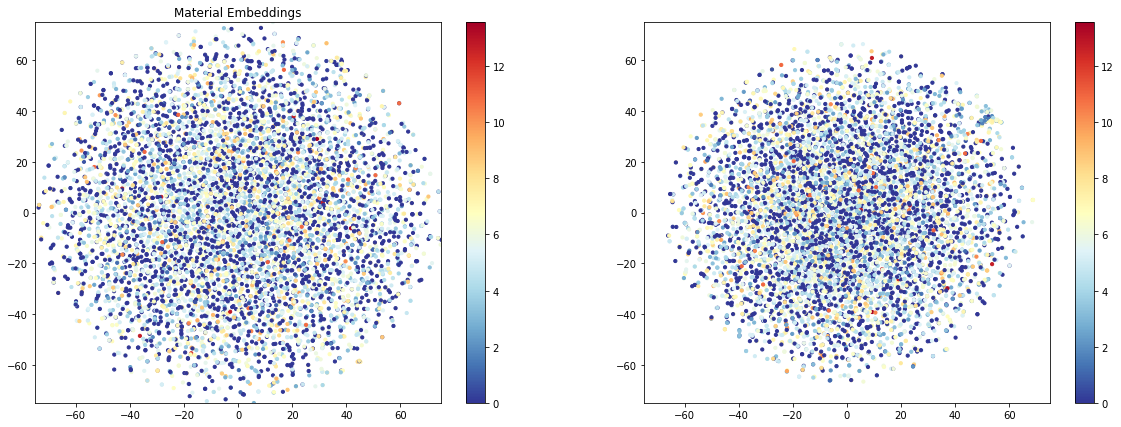

In [47]:
from sklearn.manifold import TSNE

cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

%time item_tsne = TSNE(perplexity=30).fit_transform(user_embeddings)
a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["customer_id"] = df['customer_id']
a['old_id'] = df["old_customer_id"]
a['order'] = df['order']


plt.title('Customer Embeddings')
plt.subplot(121)
sc = plt.scatter(a['x'], a['y'],s=10,c= a['order'],cmap=cm)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.colorbar(sc)


%time item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)
b = pd.DataFrame(item_tsne)
b.columns = ["x",'y']
b["material_id"] = df['material_id']
b['old_id'] = df['old_material_id']
b['order'] = df['order']

plt.title('Material Embeddings')
plt.subplot(122)
sc = plt.scatter(b['x'], b['y'],s=10, c=b['order'], cmap=cm)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.colorbar(sc)

plt.show()

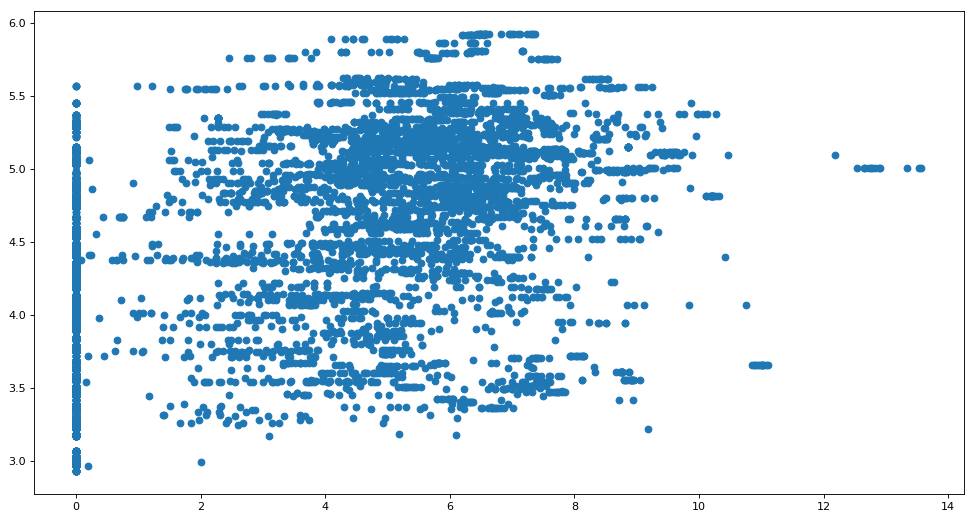

In [48]:
predictions = model.predict([df["customer_id"], df["material_id"]])

comparison = pd.concat([df['order'], pd.DataFrame(predictions).astype('float64').clip(0)], axis=1)
df['preditions'] = predictions

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(df['order'], predictions)

df.to_csv('summary.csv')